# 자동 미분
- Tensor는 경사를 자동으로 계산하는 자동 미분(autograd) 기능이 있다.
- 비교적 간단한 심층학습에 있어서는 꼭 자동 미분을 의식할 필요는 없다.
- 그러나 자동 미분의 구조를 알아두면 복잡한 모델을 유연하게 구축할 수 있게 된다.

### 자동 미분 튜토리얼
URL https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

# requires_grad 속성
Tensor는 requires_grad 속성을 True로 설정함으로써 그 각 요소가 경사계산의 대상이 된다.

In [2]:
import torch

x = torch.ones(2, 3, requires_grad=True)
print(x)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)


# Tensor의 연산 기록
requires_grad 속성이 True이면 그 Tensor 연산으로 생성된 Tensor에는 grad_fn이 기록된다. 말하자면 grad_fn은 이 Tensor를 만든 연산이다.


In [3]:
# requires_grad 속성이 True인 x에 덧셈을 하여 얻어진 y의 grad_fn을 표시한다.
y = x + 2
print(y)
print(y.grad_fn)

# grad_fn에 출력값에 <AddBackward0>이라고 표시된 의미: 덧셈을 계산한 기록이다.
# 참고) 곱셈, mean() 메서드 등의 연산도 grad_fn에 기록된다.

tensor([[3., 3., 3.],
        [3., 3., 3.]], grad_fn=<AddBackward0>)


In [4]:
z = y * 3
print(z)

out = z.mean()
print(out)

tensor([[9., 9., 9.],
        [9., 9., 9.]], grad_fn=<MulBackward0>)
tensor(9., grad_fn=<MeanBackward0>)


# 경사 계산
backward() 메서드는 역전파에 의해 경사를 계산한다.
계산 과정을 거슬러 올라가게 해서 경사가 계산되는데 그때 기록되어 있는 연산과 경로가 사용됨.

In [5]:
a = torch.tensor([1.0], requires_grad=True)
b = a * 2 # b의 변화량은 a의 2배
b.backward() # 역전파
print(a.grad) # a의 경사(a의 변화에 대한 b의 변화 비율)

tensor([2.])


### 더욱 복잡한 경로의 역전파

In [6]:
def calc(a):
  b = a*2 + 1
  c = b*b
  d = c/(c+2)
  e = d.mean()
  return e


x = [1.0, 2.0, 3.0]
x = torch.tensor(x, requires_grad=True)
y = calc(x)
y.backward()
print(x.grad) # x의 경사(x의 각 값의 변화에 대한 y의 변화 비율)

tensor([0.0661, 0.0183, 0.0072])


### 미세한 변화의 비율을 계산

In [7]:
delta = 0.001 # x의 미세한 변화

x = [1.0, 2.0, 3.0]
x = torch.tensor(x)
y = calc(x)

x_1 = [1.0+delta, 2.0, 3.0]
x_1 = torch.tensor(x_1)
y_1 = calc(x_1)

x_2 = [1.0, 2.0+delta, 3.0]
x_2 = torch.tensor(x_2)
y_2 = calc(x_2)

x_3 = [1.0, 2.0, 3.0+delta]
x_3 = torch.tensor(x_3)
y_3 = calc(x_3)


# 경사 계산(y의 미세한 변화)/(x의 메시한 변화)
grad_1 = (y_1 - y) / delta
grad_2 = (y_2 - y) / delta
grad_3 = (y_3 - y) / delta

grads = torch.stack((grad_1, grad_2, grad_3)) # Tensor를 결합
print(grads)

tensor([0.0660, 0.0183, 0.0072])


# 에포크와 배치
- 훈련 데이터를 1회 다 써서 학습하는 것: 1 에포크(epoch)라는 단위로 센다.
- 1 에포크로 훈련 데이터를 중복하지 않고 대부분 사용한다.
- 훈련 데이터의 샘플(입력과 정답의 쌍)은 여러 개를 그룹으로 합쳐서, 한 번의 학습에 사용됨.
- 이 **그룹을 배치(batch)**라고 함.
- 한 번의 학습에서는 순전파, 역전파, 파라미터의 갱신이 이뤄진다.
- 이것들은 '**배치마다**' 실행된다.
- 훈련 데이터는 '**1 에포크마다**' 무작위로 여러 개의 배치로 분할 됨.
- 배치에 포함되는 샘플 수를 배치 크기라고 한다.
- 학습할 때는 배치 안의 모든 샘플을 한 번에 사용하여 경사를 계산하고, 파라미터를 갱신한다.
- 배치 크기는 하이퍼 파라미터의 일종으로 기본적으로 학습 내내 일정하다.

- **배치 크기에 따른 학습 타입 3가지: 배치학습/온라인 학습/ 미니배치 학습**

# DataLoader
- 데이터 읽어 들이기, 전처리, 미니 배치 학습을 간단하게 구현할 수 있다.
- 이미지 크기가 조금 많아지므로 이번부터는 GPU를 사용.


### 데이터셋
URL https://pytorch.org/vision/stable/datasets/html

In [8]:
from torchvision.datasets import MNIST
from torchvision import transforms

img_size = 28 # 이미지의 높이와 폭

# 훈련 데이터를 취득
mnist_train = MNIST("./data",
                    train=True,
                    download=True,
                    transform=transforms.ToTensor()) # Tensor로 변환


# 테스트 데이터의 취득
mnist_test = MNIST("./data",
                   train=False,
                   download=True,
                   transform=transforms.ToTensor()) # Tensor로 변환

print("훈련 데이터의 수:", len(mnist_train), "테스트 데이터의 수:", len(mnist_test))


100%|██████████| 9912422/9912422 [00:00<00:00, 121192552.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41828623.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44296575.20it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19419499.25it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

훈련 데이터의 수: 60000 테스트 데이터의 수: 10000


# DataLoader의 설정
- DataLoader() 클래스를 사용하여 DataLoader를 설정함.
- DataLoader 클래스를 초기화할 때는 데이터 본체와 배치 크기를 설정함.
- shuffle=True와 같이 기술하여 데이터를 섞어 미니 배치를 꺼낼지 여부를 설정함.

In [9]:
from torch.utils.data import DataLoader

# DataLoader의 설정
batch_size = 256 # 배치크기
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)

# 모델 구축
- 간단한 심층학습 구현에서는 nn.Sequential()클래스를 사용하여 모델을 구축했는데,
- 이번은 nn.Module() 클래스를 상속한 클래스로서 모델을 구축한다.
- 이 방법이 더욱 복잡한 모델에 유연하게 대응할 수 있음.
- 이러한 클래스에서는 __init__()메서드 내에서 각 층의 초기 설정을 실시하고,
- forward()메서드 내에 순전파의 처리를 기술한다.

In [10]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(img_size*img_size, 1024) # 전결합층
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)
    self.relu = nn.ReLU() # ReLU 학습 파라미터가 없으므로 다시 사용할 수 있음

  def forward(self, x):
    x = x.view(-1, img_size*img_size) # (배치 크기, 입력 수): 이미지를 1차원으로 변환
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
net.cuda() # GPU 대응 # 이 메서드에 의해, 이로써 모델 계산은 GPU에서 이루어지게 됨.
print(net)


Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)


# 학습
- 모델을 훈련함
- DataLoader를 사용하여 미니 배치를 꺼내서 훈련 및 평가를 실시함.
- for j, (x,t) in enumerate(tain_loader): <- 미니 배치 학습 구현 코드
- 이 기술에 의해 훈련 데이터로부터 미니 배치(x, t)가 매 루프마다 꺼내짐.
- enumerate하고 있으므로 j에는 0을 시작으로 하는 루프의 횟수가 들어감.
- 1에포크 중에 여러 번 미니 배치를 사용하여 학습이 이뤄짐.
- x는 입력, t는 정답인데, 각각 cuda() 메서드에 의해 GPU 대응으로 해야함.

In [11]:
from torch import optim

# 교차 엔트로피 오차 함수
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 손실 로그
record_loss_train = []
record_loss_test = []

# 학습
for i in range(10):  # 10 에포크 학습
  net.train() # 훈련 모드
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):
    x, t = x.cuda(), t.cuda() # GPU 대응
    y = net(x)
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_train /= j+1
  record_loss_train.append(loss_train)


  net.eval() #평가모드
  loss_test = 0
  for j,(x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda() # GPU 대응
    y = net(x)
    loss = loss_fnc(y, t)
    loss_test += loss.item()

  loss_test /= j+1
  record_loss_test.append(loss_test)

  if i%1 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test", loss_test)

Epoch: 0 Loss_Train: 2.223858074431724 Loss_Test 2.1084653615951536
Epoch: 1 Loss_Train: 1.85427468736121 Loss_Test 1.4750990957021712
Epoch: 2 Loss_Train: 1.1326716204907032 Loss_Test 0.8386449545621872
Epoch: 3 Loss_Train: 0.7258222960411234 Loss_Test 0.6036846838891506
Epoch: 4 Loss_Train: 0.5674343937254966 Loss_Test 0.49901553690433503
Epoch: 5 Loss_Train: 0.48810064830678573 Loss_Test 0.4398622002452612
Epoch: 6 Loss_Train: 0.44045172346399186 Loss_Test 0.4027198825031519
Epoch: 7 Loss_Train: 0.4087933716621805 Loss_Test 0.3796364860609174
Epoch: 8 Loss_Train: 0.3853765696921247 Loss_Test 0.35721595361828806
Epoch: 9 Loss_Train: 0.36765304410711247 Loss_Test 0.34397713504731653


# 오차 추이
훈련 데이터와 테스트 데이터, 각각의 오차 추이를 그래프로 표시

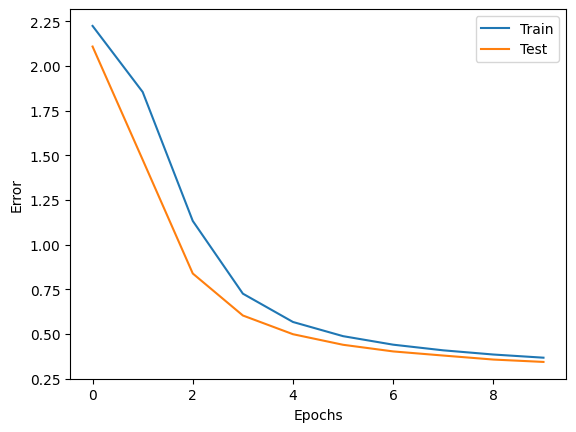

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()


# 정답률
모델의 성능 파악하기 위해 테스트 데이터를 사용하여 정답률을 측정

In [15]:
correct = 0
total = 0

net.eval() # 평가모드
for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda() # GPU 대응
  y = net(x)
  correct += (y.argmax(1) == t).sum().item()
  total += len(x)
print("정답률", str(correct/total*100) + "%")

정답률 90.10000000000001%


# 연습
배치 학습과 온라인 학습을 DataLoader를 사용하여 구현하고 결과를 비교해보자.


## 1. 데이터 읽어 들이기

In [19]:
from torchvision.datasets import MNIST
from torchvision import transforms

img_size= 28 # 이미지의 높이와 폭

# 훈련 데이터를 취득
mnist_train = MNIST("./data",
                    train=True, download=True,
                    transform=transforms.ToTensor()) # Tensor로 변환

# 테스트 데이터의 취득
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor()) # Tensor로 변환

print("훈련 데이터의 수:", len(mnist_train), "테스트 데이터의 수:", len(mnist_test))

훈련 데이터의 수: 60000 테스트 데이터의 수: 10000


## 2. DataLoader 설정

In [20]:
## DataLoader의 설정
# 온라인 학습으로 구현
# 온라인 학습은 훈련 데이터를 다 사용하는 데 시간이 걸리므로 뒤의 셀에서 에포크 수를 5정도로 설정한다.

from torch.utils.data import DataLoader

batch_size = 1

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)


In [14]:
## DataLoader의 설정
# 배치 학습으로 구현

from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=False)

## 3. 모델 구축

In [21]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(img_size*img_size, 1024) # 전결합층
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)
    self.relu = nn.ReLU() # ReLU 학습 파라미터가 없으므로 다시 사용할 수 있다.

  def forward(self, x):
    x = x.view(-1, img_size*img_size) # (배치 크기, 입력 수): 이미지를 1차원으로 변환
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
net.cuda() # GPU 대응
print(net)



Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)


##4. 학습
미니 배치 학습을 이용한 모델의 훈련

In [22]:
from torch import optim

# 교차 엔트로피 오차 함수
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 손실 로그
record_loss_train = []
record_loss_test = []

# 학습
for i in range(5):  #5 에포크 학습
  net.train() # 훈련 모드
  loss_train=0
  for j, (x, t) in enumerate(train_loader):
    x, t = x.cuda(), t.cuda() # GPU 대응
    y = net(x)
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)

  net.eval() # 평가모드
  loss_test = 0
  for j, (x, t) in enumerate(test_loader): # 미니배치(x, t)를 꺼낸다.
    x, t = x.cuda(), t.cuda() # GPU 대응
    y = net(x)
    loss = loss_fnc(y, t)
    loss_test += loss.item()
  loss_test /= j+1
  record_loss_test.append(loss_test)

  if i%1 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 0.2202452127723509 Loss_Test: 0.09712467986223844
Epoch: 1 Loss_Train: 0.08498918653792303 Loss_Test: 0.10162866535615565
Epoch: 2 Loss_Train: 0.05601703917518769 Loss_Test: 0.07027299926185875
Epoch: 3 Loss_Train: 0.03939577452984647 Loss_Test: 0.06544678759224516
Epoch: 4 Loss_Train: 0.02929468890032769 Loss_Test: 0.07017246722512673


##5. 오차 추이

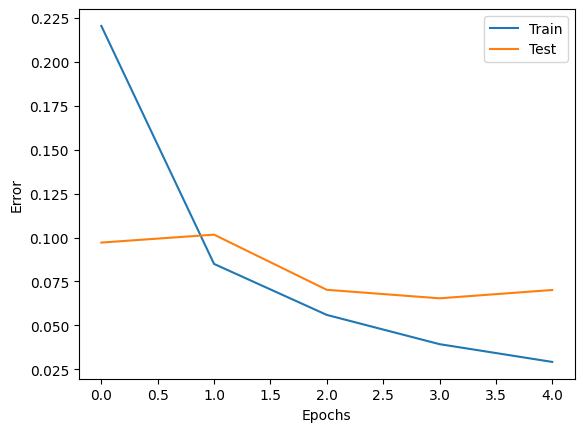

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

##6. 정답률

In [24]:
correct = 0
total = 0
net.eval() # 평가모드

for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda()
  y = net(x)

  correct += (y.argmax(1) == t).sum().item()
  total += len(x)

print("정답률:", str(correct/total*100) + "%")

정답률: 98.22999999999999%
